In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from scipy import linalg

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tnrange
import seaborn as sns
import pandas as pd
import numpy as np
from torchsummary import summary

import sys

from generative_metric import compute_generative_metric

In [2]:
sys.path.insert(0, '../models/')

In [3]:
from CVAE_first import CVAE
from CVAE_first import idx2onehot
from sample import Sample


In [4]:
sys.path.insert(0, '../losses/')

In [5]:
from ELBO import calculate_loss

In [6]:
sys.path.insert(0, '../metrics/')

In [7]:
from inception import InceptionV3
from calculate_fid import get_activations, calculate_frechet_distance
from blur import calc_blur

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transforms = transforms.Compose([transforms.ToTensor()])

In [9]:
BATCH_SIZE=50
N_EPOCHS = 15           # times to run the model on complete data
INPUT_DIM = 28 * 28 * 3     # size of each input
HIDDEN_DIM = 1024
IMAGE_CHANNELS = 3# hidden dimension
LATENT_DIM = 100        # latent vector dimension
N_CLASSES = 15          # number of classes in the data
lr = 1e-3


In [10]:
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [11]:
sys.path

['../metrics/',
 '../losses/',
 '.',
 '../models/',
 '../metrics/',
 '../models/',
 '/home/ritvik.vasan/CVAE/run_models',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python37.zip',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/lib-dynload',
 '',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/IPython/extensions',
 '/home/ritvik.vasan/.ipython']

In [12]:
def train(model, optimizer):
    # set the train mode
    model.train()
    # loss of the epoch
    train_loss = 0
    # kld loss
    kld_loss = 0
    # rcl_loss
    rcl_loss = 0

    kl_per_lt = {'Latent_Dimension': [], 'KL_Divergence': [], 'Latent_Mean': [], 'Latent_Variance': []}
    for i, (x, y) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        model.to(device)

        sm = Sample(x, y, BATCH_SIZE, device)
        x, y = sm.generate_x_y()
        x = x.view(-1,3,28,28)

        # update the gradients to zero
        optimizer.zero_grad()
        # forward pass
        reconstructed_x, z_mu, z_var, _ = model(x, y)
        # loss
        for ii in range(z_mu.size()[-1]):
            _, _, kl_per_lt_temp = calculate_loss(x, reconstructed_x, z_mu[:, ii], z_var[:, ii])
            kl_per_lt['KL_Divergence'].append(kl_per_lt_temp.item())
            kl_per_lt['Latent_Dimension'].append(ii)
            kl_per_lt['Latent_Mean'].append(z_mu[:, ii])
            kl_per_lt['Latent_Variance'].append(z_var[:, ii])
        loss, rcl, kld = calculate_loss(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()
        rcl_loss += rcl.item()
        kld_loss += kld.item()

        # update the weights
        optimizer.step()

    return train_loss, rcl_loss, kld_loss, kl_per_lt



In [13]:
inc = InceptionV3([3])
inc = inc.cuda()

def test(model, optimizer):
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0
    # kld loss
    kld_loss = 0
    # rcl_loss
    rcl_loss = 0

    kl_per_lt = {'Latent_Dimension': [], 'KL_Divergence': [], 'Latent_Mean': [], 'Latent_Variance': []}

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iterator):
            # reshape the data
            model.to(device)
            sm = Sample(x, y, BATCH_SIZE, device)
            x, y = sm.generate_x_y()

            x = x.view(-1,3,28,28)
            # forward pass
            reconstructed_x, z_mu, z_var, _ = model(x, y)
            blur = calc_blur(reconstructed_x)

            # loss
            for ii in range(z_mu.size()[-1]) :
                _, _, kl_per_lt_temp = calculate_loss(x, reconstructed_x, z_mu[:, ii], z_var[:, ii])
                
                kl_per_lt['Latent_Dimension'].append(ii)
                kl_per_lt['Latent_Mean'].append(z_mu[:, ii])
                kl_per_lt['Latent_Variance'].append(z_var[:, ii])
            loss, rcl, kld = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()
            rcl_loss += rcl.item()
            kld_loss += kld.item()

    return test_loss, rcl_loss, kld_loss, kl_per_lt, blur.data.item()



In [14]:
best_test_loss = float('inf')

modelt = CVAE(IMAGE_CHANNELS,N_CLASSES, HIDDEN_DIM, LATENT_DIM, )

optimizert = optim.Adam(modelt.parameters(), lr=lr)

dataframe = {'epoch': [], 'train_losses': [], 'train_rcl_losses': [], 'train_kl_losses': [], 'test_losses': [],
             'test_rcl_losses': [], 'test_kl_losses': [], 'fid_any_color_any_digit': [],
             'fid_color_blue_any_digit': [], 'fid_any_color_digit_0': [], 
             'fid_color_blue_digit_zero': [],
             'blur': []}

data2 = {'epoch': [], 'n_dim': [], 'kld_avg_dim': []}


In [15]:
for e in tnrange(N_EPOCHS,desc='Epochs'):

    train_loss, tr_rcl_loss, tr_kld_loss, tr_kl_per_lt = train(modelt, optimizert)
    test_loss, test_rcl_loss, test_kld_loss, test_kl_per_lt, blur = test(modelt, optimizert)

    with torch.no_grad():
        fid1, grid, grid2 = compute_generative_metric(test_iterator, modelt, device, LATENT_DIM, BATCH_SIZE, 
                                    color_value= None, digit_value=None)
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     plt.show()
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))
#     plt.show()
    
        fid2, grid, grid2 = compute_generative_metric(test_iterator, modelt, device, LATENT_DIM, BATCH_SIZE, 
                                    color_value= 0, digit_value=None)
    
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     plt.show()
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))
#     plt.show()
    
        fid3, grid, grid2 = compute_generative_metric(test_iterator, modelt, device, LATENT_DIM, BATCH_SIZE, 
                                    color_value= None, digit_value=5)
        
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     plt.show()
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))
#     plt.show()
    
        fid4, grid, grid2 = compute_generative_metric(test_iterator, modelt, device, LATENT_DIM, BATCH_SIZE, 
                                    color_value= 0, digit_value=5)

#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     plt.show()
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))
#     plt.show()
    #     with torch.no_grad():
#         im = torch.empty([0])
#         lab = torch.empty([0])
#         for j in range(10):
#             tim, tl = iter(test_iterator).next()
#             im = torch.cat((im, tim), 0)
#             lab = torch.cat((lab, tl.float()), 0)

#         im = im.repeat(1, 3, 1, 1)

#         # create a random latent vector
#         z = torch.randn(lab.size()[0], LATENT_DIM).to(device)

#         # pick randomly 1 class, for which we want to generate the data
#         y = torch.randint(0,10, (lab.size()[0], 1)).to(dtype=torch.long)
#         y = idx2onehot(y, n = 10).to(device, dtype=z.dtype)
#         # y.fill_(0)
        
#         y = torch.cat((y, torch.zeros([lab.size()[0]]).view(-1, 1).cuda()), dim = 1)
        
#         y2 = torch.randint(1, 2, (lab.size()[0], 1)).to(dtype=torch.long)
#         y2 = idx2onehot(y2, n = 3).to(device, dtype=z.dtype)
#         y2 = torch.cat((y2, torch.zeros([lab.size()[0]]).view(-1, 1).cuda()), dim = 1)
        
#         y = torch.cat((y, y2), dim = 1)
        
#         z = torch.cat((z, y), dim=1)

#         # decode
#         generated_x = modelt.decoder(z, y)

#         X_act = get_activations(im.cpu().data.numpy(), inc,
#                                 batch_size=BATCH_SIZE, dims=2048, cuda=True)
#         recon_act = get_activations(generated_x.cpu().data.numpy(), inc,
#                                     batch_size=BATCH_SIZE, dims=2048, cuda=True)

#         X_act_mu = np.mean(X_act, axis=0)
#         recon_act_mu = np.mean(recon_act, axis=0)
#         X_act_sigma = np.cov(X_act, rowvar=False)
#         recon_act_sigma = np.cov(recon_act, rowvar=False)

#         fid = calculate_frechet_distance(X_act_mu, X_act_sigma, recon_act_mu,
#                                          recon_act_sigma, eps=1e-6)

    train_loss /= len(train_dataset)
    tr_rcl_loss /= len(train_dataset)
    tr_kld_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    test_rcl_loss /= len(test_dataset)
    test_kld_loss /= len(test_dataset)
    dataframe['epoch'].append(e)
    dataframe['train_losses'].append(train_loss)
    dataframe['train_rcl_losses'].append(tr_rcl_loss)
    dataframe['train_kl_losses'].append(tr_kld_loss)
    dataframe['test_losses'].append(test_loss)
    dataframe['test_rcl_losses'].append(test_rcl_loss)
    dataframe['test_kl_losses'].append(test_kld_loss)

    dataframe['fid_any_color_any_digit'].append(fid1)
    dataframe['fid_color_blue_any_digit'].append(fid2)
    dataframe['fid_any_color_digit_0'].append(fid3)
    dataframe['fid_color_blue_digit_zero'].append(fid4)
    dataframe['blur'].append(blur)
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Train KLD Loss: {tr_kld_loss:.2f}, Test Loss: {test_loss:.2f}, Test KLD Loss: {test_kld_loss:.2f}' )
    #sns.pairplot(data = pd.DataFrame(tr_kl_per_lt), height=3, vars=["dimension"])

    df = pd.DataFrame(tr_kl_per_lt)
    df = df.sort_values(by=['KL_Divergence'])
    n_dim = np.max(df['Latent_Dimension'])

    kld_avg_dim = np.zeros(n_dim)

    for i in range(n_dim):
        kld_avg_dim[i] = np.mean(df['KL_Divergence'][df['Latent_Dimension'] == i])
    kld_avg_dim = np.sort(kld_avg_dim)[::-1]

    data2['epoch'].append(e)
    data2['n_dim'].append(n_dim)
    data2['kld_avg_dim'].append(kld_avg_dim)

    #     print(f'Epoch {e}, Train RCL loss: {tr_rcl_loss:.2f}, Test RCL Loss: {test_rcl_loss:.2f}')
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

    

        

/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 0, Train Loss: 167.85, Train KLD Loss: 11.95, Test Loss: 115.81, Test KLD Loss: 15.22


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 1, Train Loss: 110.72, Train KLD Loss: 16.47, Test Loss: 106.02, Test KLD Loss: 16.76


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 2, Train Loss: 104.96, Train KLD Loss: 17.21, Test Loss: 102.72, Test KLD Loss: 17.38


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 3, Train Loss: 102.29, Train KLD Loss: 17.50, Test Loss: 100.59, Test KLD Loss: 17.31


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 4, Train Loss: 100.47, Train KLD Loss: 17.70, Test Loss: 99.74, Test KLD Loss: 17.81


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 5, Train Loss: 99.19, Train KLD Loss: 17.87, Test Loss: 98.35, Test KLD Loss: 17.73


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 6, Train Loss: 98.23, Train KLD Loss: 17.95, Test Loss: 97.36, Test KLD Loss: 17.94


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 7, Train Loss: 97.48, Train KLD Loss: 17.99, Test Loss: 97.56, Test KLD Loss: 17.35


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 8, Train Loss: 98.33, Train KLD Loss: 18.28, Test Loss: 96.82, Test KLD Loss: 18.15


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 9, Train Loss: 96.29, Train KLD Loss: 18.12, Test Loss: 95.97, Test KLD Loss: 18.28


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 10, Train Loss: 95.92, Train KLD Loss: 18.10, Test Loss: 96.01, Test KLD Loss: 18.16


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 11, Train Loss: 95.60, Train KLD Loss: 18.12, Test Loss: 95.81, Test KLD Loss: 18.02


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 12, Train Loss: 95.38, Train KLD Loss: 18.19, Test Loss: 95.70, Test KLD Loss: 17.85


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 13, Train Loss: 95.03, Train KLD Loss: 18.17, Test Loss: 95.83, Test KLD Loss: 18.68


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 14, Train Loss: 94.81, Train KLD Loss: 18.21, Test Loss: 95.62, Test KLD Loss: 18.50



In [16]:
stats = pd.DataFrame(dataframe)

In [17]:
stats = stats.sort_values(by='epoch', ascending=False)

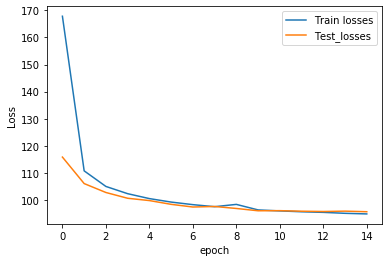

In [23]:
import seaborn as sns

sns.lineplot(data = stats, x = 'epoch', y = 'train_losses')
g = sns.lineplot(data = stats, x = 'epoch', y = 'test_losses')
g.set_ylabel('Loss')
g.legend(['Train losses', 'Test_losses'])

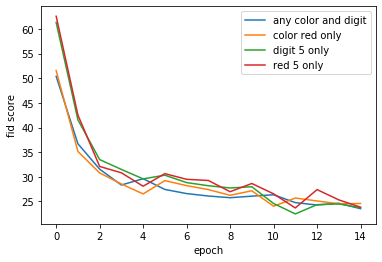

In [20]:
import seaborn as sns

sns.lineplot(data = stats, x = 'epoch', y = 'fid_any_color_any_digit')
sns.lineplot(data = stats, x = 'epoch', y = 'fid_color_blue_any_digit')
sns.lineplot(data = stats, x = 'epoch', y = 'fid_any_color_digit_0')
g = sns.lineplot(data = stats, x = 'epoch', y = 'fid_color_blue_digit_zero')
g.set_ylabel('fid score')
g.legend(['any color and digit', 'color red only', 'digit 5 only', 'red 5 only'])

In [18]:
stats

,epoch,train_losses,train_rcl_losses,train_kl_losses,test_losses,test_rcl_losses,test_kl_losses,fid_any_color_any_digit,fid_color_blue_any_digit,fid_any_color_digit_0,fid_color_blue_digit_zero,blur
0,0,165.637439,153.061707,12.575731,115.050077,98.863538,16.186539,48.945272,56.256224,53.367629,56.106185,0.006872
1,1,110.975557,94.287678,16.687879,106.948048,88.848494,18.099555,37.200727,43.638276,33.829565,39.899739,0.009450
2,2,105.172510,87.872876,17.299634,102.650695,85.297675,17.353020,29.650025,39.841629,33.761287,37.941121,0.009297
3,3,102.340361,84.822751,17.517610,100.892871,83.037785,17.855086,31.416646,39.264441,32.935076,37.905878,0.009393
4,4,100.647166,82.980554,17.666612,99.896926,82.434559,17.462366,28.094877,33.714565,29.277037,35.411062,0.009704
5,5,99.452998,81.716173,17.736825,99.776866,82.266507,17.510359,27.982538,32.724038,28.928712,33.541538,0.010185
6,6,99.034197,81.186615,17.847582,114.264609,92.338101,21.926508,35.478844,35.477278,47.504129,46.058820,0.007993
7,7,98.315020,80.255088,18.059931,97.200817,79.528047,17.672770,24.327098,31.626779,29.304324,36.760027,0.010271
8,8,97.155727,79.216928,17.938799,97.899108,79.803121,18.095986,25.933338,31.200021,27.529280,33.976110,0.010432
9,9,96.782125,78.781259,18.000866,96.718959,78.739138,17.979822,25.198856,29.185032,27.322056,33.310449,0.010735


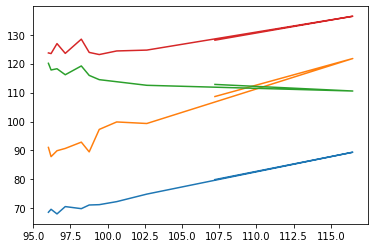

In [21]:
plt.plot(stats['test_losses'], stats['fid_any_color_any_digit'])
plt.plot(stats['test_losses'], stats['fid_color_blue_any_digit'])
plt.plot(stats['test_losses'], stats['fid_any_color_digit_0'])
plt.plot(stats['test_losses'], stats['fid_color_blue_digit_zero'])

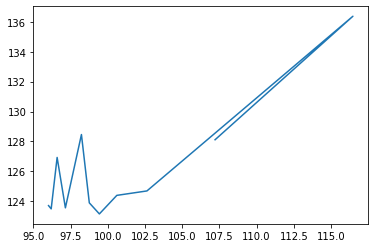

In [22]:
plt.plot(stats['test_losses'], stats['fid_color_blue_digit_zero'])

In [26]:
best_test_loss = float('inf')

modelt = CVAE(IMAGE_CHANNELS,N_CLASSES, HIDDEN_DIM, LATENT_DIM, )

optimizert = optim.Adam(modelt.parameters(), lr=lr)

dataframe = {'epoch': [], 'train_losses': [], 'train_rcl_losses': [], 'train_kl_losses': [], 'test_losses': [],
             'test_rcl_losses': [], 'test_kl_losses': [], 'fid': [], 'blur': []}

data2 = {'epoch': [], 'n_dim': [], 'kld_avg_dim': []}

In [30]:
color_value = 1
with torch.no_grad():
    im = torch.empty([0])
    lab = torch.empty([0])
    for imm, tll in iter(test_iterator):
        for tim, tl in zip(imm, tll): 
            if lab.size()[0] != 500:
                if tl == 3:
                    im = torch.cat((im, tim), 0)
                    lab = torch.cat((lab, tl.view(1).float()), 0)
            elif lab.size()[0] == 500:
                break

    im = im.view(lab.size()[0], 1, 28, 28)
    im = im.repeat(1, 3, 1, 1)

    colors = []

    for j in range(lab.size()[0]):
        if color_value is not None: 
            color = torch.randint(color_value, color_value+1, (1,1)).item()
        else:
            color = torch.randint(1, 4, (1,1)).item()
        other_indices = []
        color_index = []
        for a in [1,2,3]:
            if color != a:
                other_indices.append(a)
            else:
                color_index = a
        print(im.size(), j, other_indices[0] - 1, other_indices[1] - 1)
        im[j, other_indices[0]-1, :, :].fill_(0)
        im[j, other_indices[1]-1, :, :].fill_(0)
        colors.append(color-1)

    colors = torch.FloatTensor(colors)


torch.Size([500, 3, 28, 28]) 0 1 2
torch.Size([500, 3, 28, 28]) 1 1 2
torch.Size([500, 3, 28, 28]) 2 1 2
torch.Size([500, 3, 28, 28]) 3 1 2
torch.Size([500, 3, 28, 28]) 4 1 2
torch.Size([500, 3, 28, 28]) 5 1 2
torch.Size([500, 3, 28, 28]) 6 1 2
torch.Size([500, 3, 28, 28]) 7 1 2
torch.Size([500, 3, 28, 28]) 8 1 2
torch.Size([500, 3, 28, 28]) 9 1 2
torch.Size([500, 3, 28, 28]) 10 1 2
torch.Size([500, 3, 28, 28]) 11 1 2
torch.Size([500, 3, 28, 28]) 12 1 2
torch.Size([500, 3, 28, 28]) 13 1 2
torch.Size([500, 3, 28, 28]) 14 1 2
torch.Size([500, 3, 28, 28]) 15 1 2
torch.Size([500, 3, 28, 28]) 16 1 2
torch.Size([500, 3, 28, 28]) 17 1 2
torch.Size([500, 3, 28, 28]) 18 1 2
torch.Size([500, 3, 28, 28]) 19 1 2
torch.Size([500, 3, 28, 28]) 20 1 2
torch.Size([500, 3, 28, 28]) 21 1 2
torch.Size([500, 3, 28, 28]) 22 1 2
torch.Size([500, 3, 28, 28]) 23 1 2
torch.Size([500, 3, 28, 28]) 24 1 2
torch.Size([500, 3, 28, 28]) 25 1 2
torch.Size([500, 3, 28, 28]) 26 1 2
torch.Size([500, 3, 28, 28]) 27 1 2
to

torch.Size([500, 3, 28, 28]) 312 1 2
torch.Size([500, 3, 28, 28]) 313 1 2
torch.Size([500, 3, 28, 28]) 314 1 2
torch.Size([500, 3, 28, 28]) 315 1 2
torch.Size([500, 3, 28, 28]) 316 1 2
torch.Size([500, 3, 28, 28]) 317 1 2
torch.Size([500, 3, 28, 28]) 318 1 2
torch.Size([500, 3, 28, 28]) 319 1 2
torch.Size([500, 3, 28, 28]) 320 1 2
torch.Size([500, 3, 28, 28]) 321 1 2
torch.Size([500, 3, 28, 28]) 322 1 2
torch.Size([500, 3, 28, 28]) 323 1 2
torch.Size([500, 3, 28, 28]) 324 1 2
torch.Size([500, 3, 28, 28]) 325 1 2
torch.Size([500, 3, 28, 28]) 326 1 2
torch.Size([500, 3, 28, 28]) 327 1 2
torch.Size([500, 3, 28, 28]) 328 1 2
torch.Size([500, 3, 28, 28]) 329 1 2
torch.Size([500, 3, 28, 28]) 330 1 2
torch.Size([500, 3, 28, 28]) 331 1 2
torch.Size([500, 3, 28, 28]) 332 1 2
torch.Size([500, 3, 28, 28]) 333 1 2
torch.Size([500, 3, 28, 28]) 334 1 2
torch.Size([500, 3, 28, 28]) 335 1 2
torch.Size([500, 3, 28, 28]) 336 1 2
torch.Size([500, 3, 28, 28]) 337 1 2
torch.Size([500, 3, 28, 28]) 338 1 2
t

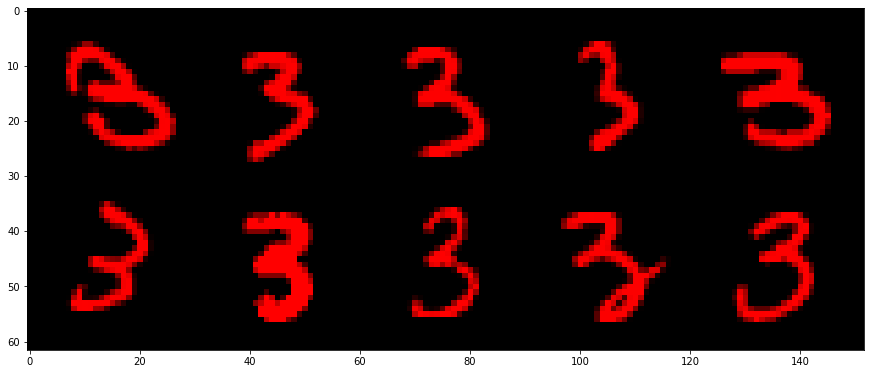

In [31]:
import torchvision
images = im[:10, :, :, :]
grid2 = torchvision.utils.make_grid(images, nrow = 5)

plt.figure(figsize = (15,  15))
plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))

In [79]:
for e in tnrange(N_EPOCHS,desc='Epochs'):

    train_loss, tr_rcl_loss, tr_kld_loss, tr_kl_per_lt = train(modelt, optimizert)
    test_loss, test_rcl_loss, test_kld_loss, test_kl_per_lt, blur = test(modelt, optimizert)

    fid = compute_generative_metric(test_iterator, modelt, color_value= None, digit_value=None, 
                                   device, LATENT_DIM, BATCH_SIZE)
#     with torch.no_grad():
#         im = torch.empty([0])
#         lab = torch.empty([0])
#         for imm, tll in iter(test_iterator):
#             for tim, tl in zip(imm, tll): 
#                 if lab.size()[0] != 500:
#                     if tl == 3:
#                         im = torch.cat((im, tim), 0)
#                         lab = torch.cat((lab, tl.view(1).float()), 0)
#                 elif lab.size()[0] == 500:
#                     break

#         im = im.view(lab.size()[0], 1, 28, 28)
#         im = im.repeat(1, 3, 1, 1)
        
#         colors = []
        
#         for j in range(lab.size()[0]):
#             color = torch.randint(1, 4, (1,1)).item()
#             other_indices = []
#             color_index = []
#             for a in [1,2,3]:
#                 if color != a:
#                     other_indices.append(a)
#                 else:
#                     color_index = a
#             print(im.size(), j, other_indices[0] - 1, other_indices[1] - 1)
#             im[j, other_indices[0]-1, :, :].fill_(0)
#             im[j, other_indices[1]-1, :, :].fill_(0)
#             colors.append(color-1)
            
#         colors = torch.FloatTensor(colors)

#         # create a random latent vector
#         z = torch.randn(lab.size()[0], LATENT_DIM).to(device)

#         # pick randomly 1 class, for which we want to generate the data
#         y = torch.randint(3,4, (lab.size()[0], 1)).to(dtype=torch.long)
#         y = idx2onehot(y, n = 10).to(device, dtype=z.dtype)
#         # y.fill_(0)
        
#         y = torch.cat((y, torch.zeros([lab.size()[0]]).view(-1, 1).cuda()), dim = 1)
        
#         y2 = torch.randint(0, 3, (lab.size()[0], 1)).to(dtype=torch.long)
#         #y2 = torch.LongTensor(colors.long())
#         y2 = idx2onehot(y2, n = 3).to(device, dtype=z.dtype)
#         y2 = torch.cat((y2, torch.zeros([lab.size()[0]]).view(-1, 1).cuda()), dim = 1)
        
#         y = torch.cat((y, y2), dim = 1)
        
#         z = torch.cat((z, y), dim=1)

#         # decode
#         generated_x = modelt.decoder(z, y)

#         X_act = get_activations(im.cpu().data.numpy(), inc,
#                                 batch_size=BATCH_SIZE, dims=2048, cuda=True)
#         recon_act = get_activations(generated_x.cpu().data.numpy(), inc,
#                                     batch_size=BATCH_SIZE, dims=2048, cuda=True)

#         X_act_mu = np.mean(X_act, axis=0)
#         recon_act_mu = np.mean(recon_act, axis=0)
#         X_act_sigma = np.cov(X_act, rowvar=False)
#         recon_act_sigma = np.cov(recon_act, rowvar=False)

#         fid = calculate_frechet_distance(X_act_mu, X_act_sigma, recon_act_mu,
#                                          recon_act_sigma, eps=1e-6)

    train_loss /= len(train_dataset)
    tr_rcl_loss /= len(train_dataset)
    tr_kld_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    test_rcl_loss /= len(test_dataset)
    test_kld_loss /= len(test_dataset)
    dataframe['epoch'].append(e)
    dataframe['train_losses'].append(train_loss)
    dataframe['train_rcl_losses'].append(tr_rcl_loss)
    dataframe['train_kl_losses'].append(tr_kld_loss)
    dataframe['test_losses'].append(test_loss)
    dataframe['test_rcl_losses'].append(test_rcl_loss)
    dataframe['test_kl_losses'].append(test_kld_loss)

    dataframe['fid'].append(fid)
    dataframe['blur'].append(blur)
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Train KLD Loss: {tr_kld_loss:.2f}, Test Loss: {test_loss:.2f}, Test KLD Loss: {test_kld_loss:.2f}' )
    #sns.pairplot(data = pd.DataFrame(tr_kl_per_lt), height=3, vars=["dimension"])
    print(f'Epoch {e}, Blur: {blur:.2f}, FID: {fid:.2f}')

    df = pd.DataFrame(tr_kl_per_lt)
    df = df.sort_values(by=['KL_Divergence'])
    n_dim = np.max(df['Latent_Dimension'])

    kld_avg_dim = np.zeros(n_dim)

    for i in range(n_dim):
        kld_avg_dim[i] = np.mean(df['KL_Divergence'][df['Latent_Dimension'] == i])
    kld_avg_dim = np.sort(kld_avg_dim)[::-1]

    data2['epoch'].append(e)
    data2['n_dim'].append(n_dim)
    data2['kld_avg_dim'].append(kld_avg_dim)

    #     print(f'Epoch {e}, Train RCL loss: {tr_rcl_loss:.2f}, Test RCL Loss: {test_rcl_loss:.2f}')
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

torch.Size([500, 3, 28, 28]) 0 0 1
torch.Size([500, 3, 28, 28]) 1 0 2
torch.Size([500, 3, 28, 28]) 2 1 2
torch.Size([500, 3, 28, 28]) 3 0 2
torch.Size([500, 3, 28, 28]) 4 0 1
torch.Size([500, 3, 28, 28]) 5 1 2
torch.Size([500, 3, 28, 28]) 6 0 1
torch.Size([500, 3, 28, 28]) 7 0 1
torch.Size([500, 3, 28, 28]) 8 0 1
torch.Size([500, 3, 28, 28]) 9 0 1
torch.Size([500, 3, 28, 28]) 10 1 2
torch.Size([500, 3, 28, 28]) 11 1 2
torch.Size([500, 3, 28, 28]) 12 0 1
torch.Size([500, 3, 28, 28]) 13 1 2
torch.Size([500, 3, 28, 28]) 14 0 1
torch.Size([500, 3, 28, 28]) 15 1 2
torch.Size([500, 3, 28, 28]) 16 0 2
torch.Size([500, 3, 28, 28]) 17 0 1
torch.Size([500, 3, 28, 28]) 18 0 2
torch.Size([500, 3, 28, 28]) 19 1 2
torch.Size([500, 3, 28, 28]) 20 1 2
torch.Size([500, 3, 28, 28]) 21 0 1
torch.Size([500, 3, 28, 28]) 22 1 2
torch.Size([500, 3, 28, 28]) 23 0 2
torch.Size([500, 3, 28, 28]) 24 0 1
torch.Size([500, 3, 28, 28]) 25 0 1
torch.Size([500, 3, 28, 28]) 26 0 2
torch.Size([500, 3, 28, 28]) 27 0 2
to

torch.Size([500, 3, 28, 28]) 328 0 1
torch.Size([500, 3, 28, 28]) 329 1 2
torch.Size([500, 3, 28, 28]) 330 1 2
torch.Size([500, 3, 28, 28]) 331 0 2
torch.Size([500, 3, 28, 28]) 332 0 2
torch.Size([500, 3, 28, 28]) 333 1 2
torch.Size([500, 3, 28, 28]) 334 0 2
torch.Size([500, 3, 28, 28]) 335 0 1
torch.Size([500, 3, 28, 28]) 336 1 2
torch.Size([500, 3, 28, 28]) 337 1 2
torch.Size([500, 3, 28, 28]) 338 0 1
torch.Size([500, 3, 28, 28]) 339 0 2
torch.Size([500, 3, 28, 28]) 340 0 2
torch.Size([500, 3, 28, 28]) 341 1 2
torch.Size([500, 3, 28, 28]) 342 0 1
torch.Size([500, 3, 28, 28]) 343 0 1
torch.Size([500, 3, 28, 28]) 344 0 2
torch.Size([500, 3, 28, 28]) 345 0 1
torch.Size([500, 3, 28, 28]) 346 1 2
torch.Size([500, 3, 28, 28]) 347 0 1
torch.Size([500, 3, 28, 28]) 348 0 2
torch.Size([500, 3, 28, 28]) 349 0 2
torch.Size([500, 3, 28, 28]) 350 1 2
torch.Size([500, 3, 28, 28]) 351 1 2
torch.Size([500, 3, 28, 28]) 352 1 2
torch.Size([500, 3, 28, 28]) 353 1 2
torch.Size([500, 3, 28, 28]) 354 0 1
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 0, Train Loss: 100.34, Train KLD Loss: 17.43, Test Loss: 99.06, Test KLD Loss: 17.36
Epoch 0, Blur: 0.01, FID: 28.66


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 0 2
torch.Size([500, 3, 28, 28]) 1 0 1
torch.Size([500, 3, 28, 28]) 2 0 2
torch.Size([500, 3, 28, 28]) 3 1 2
torch.Size([500, 3, 28, 28]) 4 0 2
torch.Size([500, 3, 28, 28]) 5 0 2
torch.Size([500, 3, 28, 28]) 6 0 1
torch.Size([500, 3, 28, 28]) 7 1 2
torch.Size([500, 3, 28, 28]) 8 1 2
torch.Size([500, 3, 28, 28]) 9 0 2
torch.Size([500, 3, 28, 28]) 10 1 2
torch.Size([500, 3, 28, 28]) 11 0 1
torch.Size([500, 3, 28, 28]) 12 0 2
torch.Size([500, 3, 28, 28]) 13 0 1
torch.Size([500, 3, 28, 28]) 14 1 2
torch.Size([500, 3, 28, 28]) 15 0 2
torch.Size([500, 3, 28, 28]) 16 0 2
torch.Size([500, 3, 28, 28]) 17 1 2
torch.Size([500, 3, 28, 28]) 18 0 1
torch.Size([500, 3, 28, 28]) 19 0 1
torch.Size([500, 3, 28, 28]) 20 1 2
torch.Size([500, 3, 28, 28]) 21 0 1
torch.Size([500, 3, 28, 28]) 22 0 2
torch.Size([500, 3, 28, 28]) 23 1 2
torch.Size([500, 3, 28, 28]) 24 0 2
torch.Size([500, 3, 28, 28]) 25 0 2
torch.Size([500, 3, 28, 28]) 26 0 2
torch.Size([500, 3, 28, 28]) 27 1 2
to

torch.Size([500, 3, 28, 28]) 362 0 2
torch.Size([500, 3, 28, 28]) 363 0 1
torch.Size([500, 3, 28, 28]) 364 0 2
torch.Size([500, 3, 28, 28]) 365 0 2
torch.Size([500, 3, 28, 28]) 366 0 1
torch.Size([500, 3, 28, 28]) 367 0 2
torch.Size([500, 3, 28, 28]) 368 0 2
torch.Size([500, 3, 28, 28]) 369 0 2
torch.Size([500, 3, 28, 28]) 370 0 1
torch.Size([500, 3, 28, 28]) 371 0 1
torch.Size([500, 3, 28, 28]) 372 1 2
torch.Size([500, 3, 28, 28]) 373 0 2
torch.Size([500, 3, 28, 28]) 374 0 1
torch.Size([500, 3, 28, 28]) 375 0 1
torch.Size([500, 3, 28, 28]) 376 0 1
torch.Size([500, 3, 28, 28]) 377 1 2
torch.Size([500, 3, 28, 28]) 378 1 2
torch.Size([500, 3, 28, 28]) 379 0 1
torch.Size([500, 3, 28, 28]) 380 0 1
torch.Size([500, 3, 28, 28]) 381 0 2
torch.Size([500, 3, 28, 28]) 382 1 2
torch.Size([500, 3, 28, 28]) 383 0 1
torch.Size([500, 3, 28, 28]) 384 0 1
torch.Size([500, 3, 28, 28]) 385 0 2
torch.Size([500, 3, 28, 28]) 386 0 2
torch.Size([500, 3, 28, 28]) 387 1 2
torch.Size([500, 3, 28, 28]) 388 0 1
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 1, Train Loss: 99.07, Train KLD Loss: 17.51, Test Loss: 98.72, Test KLD Loss: 17.54
Epoch 1, Blur: 0.01, FID: 25.94


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 0 1
torch.Size([500, 3, 28, 28]) 1 0 2
torch.Size([500, 3, 28, 28]) 2 0 2
torch.Size([500, 3, 28, 28]) 3 1 2
torch.Size([500, 3, 28, 28]) 4 0 1
torch.Size([500, 3, 28, 28]) 5 0 1
torch.Size([500, 3, 28, 28]) 6 0 1
torch.Size([500, 3, 28, 28]) 7 0 1
torch.Size([500, 3, 28, 28]) 8 0 1
torch.Size([500, 3, 28, 28]) 9 0 2
torch.Size([500, 3, 28, 28]) 10 0 1
torch.Size([500, 3, 28, 28]) 11 0 1
torch.Size([500, 3, 28, 28]) 12 0 1
torch.Size([500, 3, 28, 28]) 13 0 1
torch.Size([500, 3, 28, 28]) 14 0 2
torch.Size([500, 3, 28, 28]) 15 0 2
torch.Size([500, 3, 28, 28]) 16 1 2
torch.Size([500, 3, 28, 28]) 17 0 2
torch.Size([500, 3, 28, 28]) 18 0 2
torch.Size([500, 3, 28, 28]) 19 0 2
torch.Size([500, 3, 28, 28]) 20 0 2
torch.Size([500, 3, 28, 28]) 21 1 2
torch.Size([500, 3, 28, 28]) 22 0 1
torch.Size([500, 3, 28, 28]) 23 0 1
torch.Size([500, 3, 28, 28]) 24 1 2
torch.Size([500, 3, 28, 28]) 25 0 1
torch.Size([500, 3, 28, 28]) 26 0 1
torch.Size([500, 3, 28, 28]) 27 0 1
to

torch.Size([500, 3, 28, 28]) 391 0 2
torch.Size([500, 3, 28, 28]) 392 0 2
torch.Size([500, 3, 28, 28]) 393 0 1
torch.Size([500, 3, 28, 28]) 394 0 2
torch.Size([500, 3, 28, 28]) 395 0 2
torch.Size([500, 3, 28, 28]) 396 0 1
torch.Size([500, 3, 28, 28]) 397 1 2
torch.Size([500, 3, 28, 28]) 398 0 1
torch.Size([500, 3, 28, 28]) 399 0 1
torch.Size([500, 3, 28, 28]) 400 0 2
torch.Size([500, 3, 28, 28]) 401 0 2
torch.Size([500, 3, 28, 28]) 402 0 1
torch.Size([500, 3, 28, 28]) 403 1 2
torch.Size([500, 3, 28, 28]) 404 1 2
torch.Size([500, 3, 28, 28]) 405 0 2
torch.Size([500, 3, 28, 28]) 406 1 2
torch.Size([500, 3, 28, 28]) 407 1 2
torch.Size([500, 3, 28, 28]) 408 0 2
torch.Size([500, 3, 28, 28]) 409 0 2
torch.Size([500, 3, 28, 28]) 410 0 2
torch.Size([500, 3, 28, 28]) 411 0 2
torch.Size([500, 3, 28, 28]) 412 0 2
torch.Size([500, 3, 28, 28]) 413 0 2
torch.Size([500, 3, 28, 28]) 414 0 1
torch.Size([500, 3, 28, 28]) 415 0 1
torch.Size([500, 3, 28, 28]) 416 1 2
torch.Size([500, 3, 28, 28]) 417 1 2
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 2, Train Loss: 99.30, Train KLD Loss: 17.78, Test Loss: 98.59, Test KLD Loss: 17.60
Epoch 2, Blur: 0.01, FID: 27.56


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 0 1
torch.Size([500, 3, 28, 28]) 1 1 2
torch.Size([500, 3, 28, 28]) 2 0 2
torch.Size([500, 3, 28, 28]) 3 1 2
torch.Size([500, 3, 28, 28]) 4 0 1
torch.Size([500, 3, 28, 28]) 5 0 2
torch.Size([500, 3, 28, 28]) 6 0 2
torch.Size([500, 3, 28, 28]) 7 0 2
torch.Size([500, 3, 28, 28]) 8 1 2
torch.Size([500, 3, 28, 28]) 9 1 2
torch.Size([500, 3, 28, 28]) 10 0 1
torch.Size([500, 3, 28, 28]) 11 1 2
torch.Size([500, 3, 28, 28]) 12 0 1
torch.Size([500, 3, 28, 28]) 13 1 2
torch.Size([500, 3, 28, 28]) 14 0 1
torch.Size([500, 3, 28, 28]) 15 0 2
torch.Size([500, 3, 28, 28]) 16 1 2
torch.Size([500, 3, 28, 28]) 17 1 2
torch.Size([500, 3, 28, 28]) 18 0 1
torch.Size([500, 3, 28, 28]) 19 0 1
torch.Size([500, 3, 28, 28]) 20 0 2
torch.Size([500, 3, 28, 28]) 21 0 1
torch.Size([500, 3, 28, 28]) 22 1 2
torch.Size([500, 3, 28, 28]) 23 0 1
torch.Size([500, 3, 28, 28]) 24 0 1
torch.Size([500, 3, 28, 28]) 25 0 2
torch.Size([500, 3, 28, 28]) 26 0 1
torch.Size([500, 3, 28, 28]) 27 1 2
to

torch.Size([500, 3, 28, 28]) 372 0 1
torch.Size([500, 3, 28, 28]) 373 0 1
torch.Size([500, 3, 28, 28]) 374 1 2
torch.Size([500, 3, 28, 28]) 375 1 2
torch.Size([500, 3, 28, 28]) 376 0 1
torch.Size([500, 3, 28, 28]) 377 0 2
torch.Size([500, 3, 28, 28]) 378 1 2
torch.Size([500, 3, 28, 28]) 379 0 1
torch.Size([500, 3, 28, 28]) 380 1 2
torch.Size([500, 3, 28, 28]) 381 0 2
torch.Size([500, 3, 28, 28]) 382 0 1
torch.Size([500, 3, 28, 28]) 383 1 2
torch.Size([500, 3, 28, 28]) 384 0 1
torch.Size([500, 3, 28, 28]) 385 1 2
torch.Size([500, 3, 28, 28]) 386 0 1
torch.Size([500, 3, 28, 28]) 387 0 2
torch.Size([500, 3, 28, 28]) 388 0 1
torch.Size([500, 3, 28, 28]) 389 0 1
torch.Size([500, 3, 28, 28]) 390 1 2
torch.Size([500, 3, 28, 28]) 391 1 2
torch.Size([500, 3, 28, 28]) 392 0 2
torch.Size([500, 3, 28, 28]) 393 0 2
torch.Size([500, 3, 28, 28]) 394 0 1
torch.Size([500, 3, 28, 28]) 395 1 2
torch.Size([500, 3, 28, 28]) 396 0 1
torch.Size([500, 3, 28, 28]) 397 1 2
torch.Size([500, 3, 28, 28]) 398 0 1
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 3, Train Loss: 97.25, Train KLD Loss: 17.73, Test Loss: 96.86, Test KLD Loss: 17.56
Epoch 3, Blur: 0.01, FID: 23.23


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 0 1
torch.Size([500, 3, 28, 28]) 1 1 2
torch.Size([500, 3, 28, 28]) 2 1 2
torch.Size([500, 3, 28, 28]) 3 0 2
torch.Size([500, 3, 28, 28]) 4 1 2
torch.Size([500, 3, 28, 28]) 5 0 2
torch.Size([500, 3, 28, 28]) 6 0 2
torch.Size([500, 3, 28, 28]) 7 0 2
torch.Size([500, 3, 28, 28]) 8 1 2
torch.Size([500, 3, 28, 28]) 9 1 2
torch.Size([500, 3, 28, 28]) 10 1 2
torch.Size([500, 3, 28, 28]) 11 0 2
torch.Size([500, 3, 28, 28]) 12 0 1
torch.Size([500, 3, 28, 28]) 13 0 2
torch.Size([500, 3, 28, 28]) 14 1 2
torch.Size([500, 3, 28, 28]) 15 1 2
torch.Size([500, 3, 28, 28]) 16 0 1
torch.Size([500, 3, 28, 28]) 17 0 2
torch.Size([500, 3, 28, 28]) 18 1 2
torch.Size([500, 3, 28, 28]) 19 0 2
torch.Size([500, 3, 28, 28]) 20 0 2
torch.Size([500, 3, 28, 28]) 21 0 1
torch.Size([500, 3, 28, 28]) 22 1 2
torch.Size([500, 3, 28, 28]) 23 0 2
torch.Size([500, 3, 28, 28]) 24 1 2
torch.Size([500, 3, 28, 28]) 25 0 2
torch.Size([500, 3, 28, 28]) 26 0 2
torch.Size([500, 3, 28, 28]) 27 0 2
to

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 4, Train Loss: 96.61, Train KLD Loss: 17.73, Test Loss: 96.75, Test KLD Loss: 17.44
Epoch 4, Blur: 0.01, FID: 23.43


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 1 2
torch.Size([500, 3, 28, 28]) 1 0 1
torch.Size([500, 3, 28, 28]) 2 1 2
torch.Size([500, 3, 28, 28]) 3 0 1
torch.Size([500, 3, 28, 28]) 4 0 2
torch.Size([500, 3, 28, 28]) 5 0 1
torch.Size([500, 3, 28, 28]) 6 0 2
torch.Size([500, 3, 28, 28]) 7 1 2
torch.Size([500, 3, 28, 28]) 8 1 2
torch.Size([500, 3, 28, 28]) 9 0 1
torch.Size([500, 3, 28, 28]) 10 1 2
torch.Size([500, 3, 28, 28]) 11 1 2
torch.Size([500, 3, 28, 28]) 12 0 2
torch.Size([500, 3, 28, 28]) 13 0 2
torch.Size([500, 3, 28, 28]) 14 0 1
torch.Size([500, 3, 28, 28]) 15 0 1
torch.Size([500, 3, 28, 28]) 16 1 2
torch.Size([500, 3, 28, 28]) 17 0 1
torch.Size([500, 3, 28, 28]) 18 1 2
torch.Size([500, 3, 28, 28]) 19 0 1
torch.Size([500, 3, 28, 28]) 20 1 2
torch.Size([500, 3, 28, 28]) 21 0 2
torch.Size([500, 3, 28, 28]) 22 0 2
torch.Size([500, 3, 28, 28]) 23 0 1
torch.Size([500, 3, 28, 28]) 24 0 1
torch.Size([500, 3, 28, 28]) 25 0 2
torch.Size([500, 3, 28, 28]) 26 0 1
torch.Size([500, 3, 28, 28]) 27 0 1
to

torch.Size([500, 3, 28, 28]) 375 0 1
torch.Size([500, 3, 28, 28]) 376 0 1
torch.Size([500, 3, 28, 28]) 377 1 2
torch.Size([500, 3, 28, 28]) 378 1 2
torch.Size([500, 3, 28, 28]) 379 1 2
torch.Size([500, 3, 28, 28]) 380 1 2
torch.Size([500, 3, 28, 28]) 381 0 2
torch.Size([500, 3, 28, 28]) 382 0 2
torch.Size([500, 3, 28, 28]) 383 0 1
torch.Size([500, 3, 28, 28]) 384 0 1
torch.Size([500, 3, 28, 28]) 385 0 2
torch.Size([500, 3, 28, 28]) 386 0 1
torch.Size([500, 3, 28, 28]) 387 0 2
torch.Size([500, 3, 28, 28]) 388 1 2
torch.Size([500, 3, 28, 28]) 389 1 2
torch.Size([500, 3, 28, 28]) 390 1 2
torch.Size([500, 3, 28, 28]) 391 0 2
torch.Size([500, 3, 28, 28]) 392 1 2
torch.Size([500, 3, 28, 28]) 393 0 2
torch.Size([500, 3, 28, 28]) 394 0 2
torch.Size([500, 3, 28, 28]) 395 1 2
torch.Size([500, 3, 28, 28]) 396 0 1
torch.Size([500, 3, 28, 28]) 397 0 1
torch.Size([500, 3, 28, 28]) 398 0 1
torch.Size([500, 3, 28, 28]) 399 0 2
torch.Size([500, 3, 28, 28]) 400 1 2
torch.Size([500, 3, 28, 28]) 401 0 1
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 5, Train Loss: 96.19, Train KLD Loss: 17.78, Test Loss: 96.26, Test KLD Loss: 17.42
Epoch 5, Blur: 0.01, FID: 21.39


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 0 2
torch.Size([500, 3, 28, 28]) 1 1 2
torch.Size([500, 3, 28, 28]) 2 0 1
torch.Size([500, 3, 28, 28]) 3 0 1
torch.Size([500, 3, 28, 28]) 4 1 2
torch.Size([500, 3, 28, 28]) 5 1 2
torch.Size([500, 3, 28, 28]) 6 0 2
torch.Size([500, 3, 28, 28]) 7 0 2
torch.Size([500, 3, 28, 28]) 8 0 2
torch.Size([500, 3, 28, 28]) 9 1 2
torch.Size([500, 3, 28, 28]) 10 1 2
torch.Size([500, 3, 28, 28]) 11 1 2
torch.Size([500, 3, 28, 28]) 12 1 2
torch.Size([500, 3, 28, 28]) 13 0 2
torch.Size([500, 3, 28, 28]) 14 1 2
torch.Size([500, 3, 28, 28]) 15 0 2
torch.Size([500, 3, 28, 28]) 16 1 2
torch.Size([500, 3, 28, 28]) 17 0 2
torch.Size([500, 3, 28, 28]) 18 1 2
torch.Size([500, 3, 28, 28]) 19 0 1
torch.Size([500, 3, 28, 28]) 20 0 1
torch.Size([500, 3, 28, 28]) 21 1 2
torch.Size([500, 3, 28, 28]) 22 1 2
torch.Size([500, 3, 28, 28]) 23 0 2
torch.Size([500, 3, 28, 28]) 24 0 2
torch.Size([500, 3, 28, 28]) 25 1 2
torch.Size([500, 3, 28, 28]) 26 1 2
torch.Size([500, 3, 28, 28]) 27 0 2
to

torch.Size([500, 3, 28, 28]) 372 1 2
torch.Size([500, 3, 28, 28]) 373 0 1
torch.Size([500, 3, 28, 28]) 374 0 1
torch.Size([500, 3, 28, 28]) 375 0 1
torch.Size([500, 3, 28, 28]) 376 0 2
torch.Size([500, 3, 28, 28]) 377 1 2
torch.Size([500, 3, 28, 28]) 378 1 2
torch.Size([500, 3, 28, 28]) 379 1 2
torch.Size([500, 3, 28, 28]) 380 0 2
torch.Size([500, 3, 28, 28]) 381 1 2
torch.Size([500, 3, 28, 28]) 382 0 2
torch.Size([500, 3, 28, 28]) 383 0 2
torch.Size([500, 3, 28, 28]) 384 0 1
torch.Size([500, 3, 28, 28]) 385 0 1
torch.Size([500, 3, 28, 28]) 386 1 2
torch.Size([500, 3, 28, 28]) 387 0 1
torch.Size([500, 3, 28, 28]) 388 0 1
torch.Size([500, 3, 28, 28]) 389 0 2
torch.Size([500, 3, 28, 28]) 390 0 2
torch.Size([500, 3, 28, 28]) 391 0 1
torch.Size([500, 3, 28, 28]) 392 0 2
torch.Size([500, 3, 28, 28]) 393 1 2
torch.Size([500, 3, 28, 28]) 394 0 2
torch.Size([500, 3, 28, 28]) 395 0 2
torch.Size([500, 3, 28, 28]) 396 0 1
torch.Size([500, 3, 28, 28]) 397 0 1
torch.Size([500, 3, 28, 28]) 398 0 2
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 6, Train Loss: 95.79, Train KLD Loss: 17.76, Test Loss: 95.96, Test KLD Loss: 17.59
Epoch 6, Blur: 0.01, FID: 22.54


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 0 2
torch.Size([500, 3, 28, 28]) 1 1 2
torch.Size([500, 3, 28, 28]) 2 0 2
torch.Size([500, 3, 28, 28]) 3 0 1
torch.Size([500, 3, 28, 28]) 4 0 1
torch.Size([500, 3, 28, 28]) 5 0 1
torch.Size([500, 3, 28, 28]) 6 0 1
torch.Size([500, 3, 28, 28]) 7 0 2
torch.Size([500, 3, 28, 28]) 8 1 2
torch.Size([500, 3, 28, 28]) 9 0 1
torch.Size([500, 3, 28, 28]) 10 0 1
torch.Size([500, 3, 28, 28]) 11 0 2
torch.Size([500, 3, 28, 28]) 12 0 2
torch.Size([500, 3, 28, 28]) 13 1 2
torch.Size([500, 3, 28, 28]) 14 0 2
torch.Size([500, 3, 28, 28]) 15 1 2
torch.Size([500, 3, 28, 28]) 16 0 1
torch.Size([500, 3, 28, 28]) 17 1 2
torch.Size([500, 3, 28, 28]) 18 0 1
torch.Size([500, 3, 28, 28]) 19 1 2
torch.Size([500, 3, 28, 28]) 20 0 2
torch.Size([500, 3, 28, 28]) 21 0 2
torch.Size([500, 3, 28, 28]) 22 0 2
torch.Size([500, 3, 28, 28]) 23 0 2
torch.Size([500, 3, 28, 28]) 24 0 1
torch.Size([500, 3, 28, 28]) 25 0 1
torch.Size([500, 3, 28, 28]) 26 0 2
torch.Size([500, 3, 28, 28]) 27 1 2
to

torch.Size([500, 3, 28, 28]) 349 0 2
torch.Size([500, 3, 28, 28]) 350 0 2
torch.Size([500, 3, 28, 28]) 351 0 1
torch.Size([500, 3, 28, 28]) 352 0 2
torch.Size([500, 3, 28, 28]) 353 0 1
torch.Size([500, 3, 28, 28]) 354 0 1
torch.Size([500, 3, 28, 28]) 355 0 1
torch.Size([500, 3, 28, 28]) 356 0 1
torch.Size([500, 3, 28, 28]) 357 1 2
torch.Size([500, 3, 28, 28]) 358 0 2
torch.Size([500, 3, 28, 28]) 359 1 2
torch.Size([500, 3, 28, 28]) 360 1 2
torch.Size([500, 3, 28, 28]) 361 0 1
torch.Size([500, 3, 28, 28]) 362 0 1
torch.Size([500, 3, 28, 28]) 363 0 1
torch.Size([500, 3, 28, 28]) 364 0 2
torch.Size([500, 3, 28, 28]) 365 0 1
torch.Size([500, 3, 28, 28]) 366 0 2
torch.Size([500, 3, 28, 28]) 367 0 2
torch.Size([500, 3, 28, 28]) 368 0 2
torch.Size([500, 3, 28, 28]) 369 0 1
torch.Size([500, 3, 28, 28]) 370 1 2
torch.Size([500, 3, 28, 28]) 371 0 2
torch.Size([500, 3, 28, 28]) 372 0 1
torch.Size([500, 3, 28, 28]) 373 1 2
torch.Size([500, 3, 28, 28]) 374 1 2
torch.Size([500, 3, 28, 28]) 375 0 2
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 7, Train Loss: 95.42, Train KLD Loss: 17.82, Test Loss: 95.77, Test KLD Loss: 17.86
Epoch 7, Blur: 0.01, FID: 22.44


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 0 2
torch.Size([500, 3, 28, 28]) 1 0 1
torch.Size([500, 3, 28, 28]) 2 0 1
torch.Size([500, 3, 28, 28]) 3 0 2
torch.Size([500, 3, 28, 28]) 4 0 2
torch.Size([500, 3, 28, 28]) 5 0 1
torch.Size([500, 3, 28, 28]) 6 1 2
torch.Size([500, 3, 28, 28]) 7 0 2
torch.Size([500, 3, 28, 28]) 8 1 2
torch.Size([500, 3, 28, 28]) 9 1 2
torch.Size([500, 3, 28, 28]) 10 1 2
torch.Size([500, 3, 28, 28]) 11 1 2
torch.Size([500, 3, 28, 28]) 12 1 2
torch.Size([500, 3, 28, 28]) 13 0 1
torch.Size([500, 3, 28, 28]) 14 0 1
torch.Size([500, 3, 28, 28]) 15 1 2
torch.Size([500, 3, 28, 28]) 16 1 2
torch.Size([500, 3, 28, 28]) 17 1 2
torch.Size([500, 3, 28, 28]) 18 0 1
torch.Size([500, 3, 28, 28]) 19 0 2
torch.Size([500, 3, 28, 28]) 20 0 1
torch.Size([500, 3, 28, 28]) 21 0 2
torch.Size([500, 3, 28, 28]) 22 0 1
torch.Size([500, 3, 28, 28]) 23 0 2
torch.Size([500, 3, 28, 28]) 24 0 2
torch.Size([500, 3, 28, 28]) 25 0 1
torch.Size([500, 3, 28, 28]) 26 0 2
torch.Size([500, 3, 28, 28]) 27 0 1
to

torch.Size([500, 3, 28, 28]) 358 1 2
torch.Size([500, 3, 28, 28]) 359 1 2
torch.Size([500, 3, 28, 28]) 360 0 2
torch.Size([500, 3, 28, 28]) 361 1 2
torch.Size([500, 3, 28, 28]) 362 0 1
torch.Size([500, 3, 28, 28]) 363 0 2
torch.Size([500, 3, 28, 28]) 364 0 1
torch.Size([500, 3, 28, 28]) 365 0 2
torch.Size([500, 3, 28, 28]) 366 1 2
torch.Size([500, 3, 28, 28]) 367 0 1
torch.Size([500, 3, 28, 28]) 368 0 2
torch.Size([500, 3, 28, 28]) 369 1 2
torch.Size([500, 3, 28, 28]) 370 0 2
torch.Size([500, 3, 28, 28]) 371 1 2
torch.Size([500, 3, 28, 28]) 372 1 2
torch.Size([500, 3, 28, 28]) 373 0 1
torch.Size([500, 3, 28, 28]) 374 0 2
torch.Size([500, 3, 28, 28]) 375 1 2
torch.Size([500, 3, 28, 28]) 376 0 1
torch.Size([500, 3, 28, 28]) 377 1 2
torch.Size([500, 3, 28, 28]) 378 0 1
torch.Size([500, 3, 28, 28]) 379 0 1
torch.Size([500, 3, 28, 28]) 380 0 1
torch.Size([500, 3, 28, 28]) 381 1 2
torch.Size([500, 3, 28, 28]) 382 0 1
torch.Size([500, 3, 28, 28]) 383 1 2
torch.Size([500, 3, 28, 28]) 384 0 2
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 8, Train Loss: 95.16, Train KLD Loss: 17.86, Test Loss: 95.30, Test KLD Loss: 17.93
Epoch 8, Blur: 0.01, FID: 21.13


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([500, 3, 28, 28]) 0 0 2
torch.Size([500, 3, 28, 28]) 1 0 1
torch.Size([500, 3, 28, 28]) 2 0 1
torch.Size([500, 3, 28, 28]) 3 0 2
torch.Size([500, 3, 28, 28]) 4 0 2
torch.Size([500, 3, 28, 28]) 5 0 2
torch.Size([500, 3, 28, 28]) 6 1 2
torch.Size([500, 3, 28, 28]) 7 0 2
torch.Size([500, 3, 28, 28]) 8 0 2
torch.Size([500, 3, 28, 28]) 9 1 2
torch.Size([500, 3, 28, 28]) 10 0 1
torch.Size([500, 3, 28, 28]) 11 0 1
torch.Size([500, 3, 28, 28]) 12 0 2
torch.Size([500, 3, 28, 28]) 13 0 1
torch.Size([500, 3, 28, 28]) 14 1 2
torch.Size([500, 3, 28, 28]) 15 0 1
torch.Size([500, 3, 28, 28]) 16 1 2
torch.Size([500, 3, 28, 28]) 17 0 2
torch.Size([500, 3, 28, 28]) 18 0 1
torch.Size([500, 3, 28, 28]) 19 1 2
torch.Size([500, 3, 28, 28]) 20 0 1
torch.Size([500, 3, 28, 28]) 21 1 2
torch.Size([500, 3, 28, 28]) 22 0 2
torch.Size([500, 3, 28, 28]) 23 0 2
torch.Size([500, 3, 28, 28]) 24 0 1
torch.Size([500, 3, 28, 28]) 25 0 2
torch.Size([500, 3, 28, 28]) 26 1 2
torch.Size([500, 3, 28, 28]) 27 0 2
to

torch.Size([500, 3, 28, 28]) 367 1 2
torch.Size([500, 3, 28, 28]) 368 1 2
torch.Size([500, 3, 28, 28]) 369 0 1
torch.Size([500, 3, 28, 28]) 370 0 1
torch.Size([500, 3, 28, 28]) 371 0 2
torch.Size([500, 3, 28, 28]) 372 0 2
torch.Size([500, 3, 28, 28]) 373 0 2
torch.Size([500, 3, 28, 28]) 374 0 2
torch.Size([500, 3, 28, 28]) 375 1 2
torch.Size([500, 3, 28, 28]) 376 0 1
torch.Size([500, 3, 28, 28]) 377 1 2
torch.Size([500, 3, 28, 28]) 378 0 2
torch.Size([500, 3, 28, 28]) 379 0 2
torch.Size([500, 3, 28, 28]) 380 0 1
torch.Size([500, 3, 28, 28]) 381 0 1
torch.Size([500, 3, 28, 28]) 382 0 2
torch.Size([500, 3, 28, 28]) 383 0 2
torch.Size([500, 3, 28, 28]) 384 1 2
torch.Size([500, 3, 28, 28]) 385 1 2
torch.Size([500, 3, 28, 28]) 386 0 1
torch.Size([500, 3, 28, 28]) 387 0 1
torch.Size([500, 3, 28, 28]) 388 0 1
torch.Size([500, 3, 28, 28]) 389 0 2
torch.Size([500, 3, 28, 28]) 390 0 2
torch.Size([500, 3, 28, 28]) 391 1 2
torch.Size([500, 3, 28, 28]) 392 0 2
torch.Size([500, 3, 28, 28]) 393 0 2
t

../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 9, Train Loss: 94.79, Train KLD Loss: 17.89, Test Loss: 95.00, Test KLD Loss: 17.53
Epoch 9, Blur: 0.01, FID: 21.23


In [116]:
stats = pd.DataFrame(dataframe)

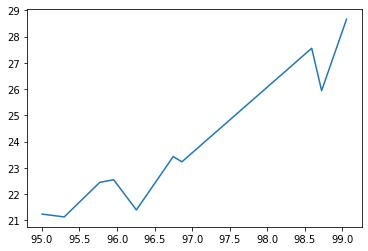

In [118]:
plt.plot(stats['test_losses'], stats['fid'])

In [101]:
modelt.encoder.conv1.conv.weight.shape

torch.Size([64, 3, 4, 4])

In [107]:
modelt.encoder.conv1.conv_condition.weight.shape

torch.Size([64, 15, 1, 1])

In [108]:
modelt.encoder.conv2.conv.weight.shape

torch.Size([128, 64, 4, 4])

In [109]:
modelt.encoder.conv2.conv_condition.weight.shape

torch.Size([128, 15, 1, 1])

In [114]:
modelt.encoder.mu.weight.shape

torch.Size([100, 1024])

In [110]:
modelt

CVAE(
  (encoder): Encoder(
    (conv1): ConditionLayer(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (conv_condition): Conv2d(15, 64, kernel_size=(1, 1), stride=(1, 1))
      (activation): ReLU()
    )
    (conv2): ConditionLayer(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (conv_condition): Conv2d(15, 128, kernel_size=(1, 1), stride=(1, 1))
      (activation): ReLU()
    )
    (conv3): ConditionLayer(
      (conv): Conv2d(128, 1024, kernel_size=(4, 4), stride=(2, 2))
      (conv_condition): Conv2d(15, 1024, kernel_size=(1, 1), stride=(1, 1))
      (activation): ReLU()
    )
    (mu): Linear(in_features=1024, out_features=100, bias=True)
    (var): Linear(in_features=1024, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (latent_to_hidden): Linear(in_features=115, out_features=1024, bias=True)
    (conv1): ConditionLayer(
      (conv): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
      (conv_condition): Conv

In [111]:
modelt.decoder.latent_to_hidden.weight.shape

torch.Size([1024, 115])

In [113]:
modelt.decoder.conv2.conv.weight.shape

torch.Size([128, 64, 5, 5])